In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
from PIL import Image

from utils import resize_and_crop

In [3]:
import PIL; PIL.__version__

'9.5.0'

### Load the dataset

In [4]:
np.random.seed(0)

In [5]:
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=None)
X_train, y_train = mnist_train.data, mnist_train.targets
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=None)
X_test, y_test = mnist_test.data, mnist_test.targets

In [6]:
X_train.min(), X_train.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [7]:
# Only the digits 0, 1, and 2 were used in the target dataset
target_idx = np.where(y_train < 3)[0] 
foreground = X_train[target_idx,:][:10000].reshape(-1, 28*28) / 255. # why 256 in the source code? -> wrong!
target_labels = y_train[target_idx][:10000]

In [8]:
foreground.max(), foreground.min()

(tensor(1.), tensor(0.))

In [9]:
IMAGENET_PATH = "./data/imagenet/grass_images/"

grass_imgs = []
for fpath in Path(IMAGENET_PATH).iterdir():
    if fpath.suffix != ".JPEG": 
        print("unknown file extension:", fpath)
        continue

    try:
        im = Image.open(fpath)
        im = im.convert(mode="L") # grayscale
        im = resize_and_crop(im) # resize and crop to 100px x 100px
        grass_imgs.append(np.reshape(im, 10000))
    except Exception as e:
        print(e)
        print("unknown error:", fpath)
    
grass_imgs = np.asarray(grass_imgs, dtype=float) / 255. # rescale to 0-1
print(grass_imgs.shape)

(1274, 10000)


In [11]:
rand_idxs = np.random.permutation(grass_imgs.shape[0])
split = int(len(rand_idxs)) // 2

target_idxs = rand_idxs[:split]
background_idxs = rand_idxs[split:]

target = np.zeros(foreground.shape)
background = np.zeros(foreground.shape)

for i in range(target.shape[0]):
    idx = np.random.choice(target_idxs) # randomly pick an image
    loc = np.random.randint(70, size=(2)) # TODO: why 70?
    
    grass_img = np.reshape(grass_imgs[idx,:], (100,100))
    superimposed_patch = np.reshape(grass_img[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28],(1,784)) # randomly pick a region in the grass image
    # target[i] = 0.5*foreground[i] + 0.5 * superimposed_patch # TODO: why 0.5 scaling factor?
                                                             # fixed to 0.5 each to maintain range to (0, 1)
    target[i] = 0.5*foreground[i] + superimposed_patch
    
    idx = np.random.choice(background_idxs)
    loc = np.random.randint(70, size=(2))
    grass_img = np.reshape(grass_imgs[idx,:], (100,100))
    background_patch = np.reshape(grass_img[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28],(1,784))
    background[i] = background_patch

In [12]:
target.max(), target.min()

(1.5, 0.0)

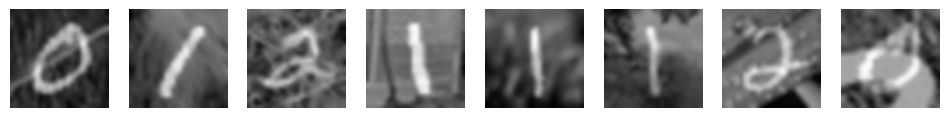

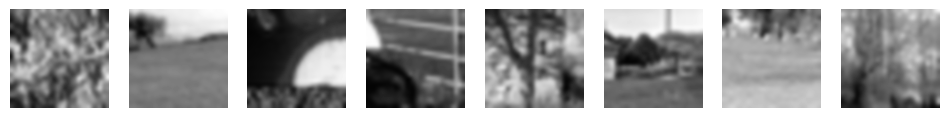

In [13]:
n_show = 8

_, axes = plt.subplots(ncols=n_show, figsize=(12,12))
for i in range(n_show):
    axes[i].imshow(np.reshape(target[i,:], (28,28)), cmap="gray", interpolation="bicubic")
    axes[i].axis("off")
    
_, axes = plt.subplots(ncols=n_show, figsize=(12,12))
for i in range(n_show):
    axes[i].imshow(np.reshape(background[i,:], (28,28)), cmap="gray", interpolation="bicubic")
    axes[i].axis("off")

In [14]:
# create dataloader

batch_size = 128
train_loader = DataLoader(dataset=target.astype("float32"), batch_size=batch_size, shuffle=True)

## VAE

1. standard VAE (or fully-connected)

In [15]:
import torch.nn as nn
from torch.optim import Adam

class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            # nn.Sigmoid(), ## added to make range (0, 1)
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar
    
    def reparameterization(self, mean, var):
        eps = torch.randn_like(var)
        return mean + var * eps
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [32]:
import torch.nn.functional as F
def loss_function(x, x_hat, mean, log_var, beta=1):
    reconstruction_loss = F.mse_loss(x_hat, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # print(reconstruction_loss, kl_loss)
    return reconstruction_loss + beta*kl_loss

In [33]:
def train(model, optimizer, epochs):
    model.train()
    
    losses = []
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(train_loader):
            # x = x.view(batch_size, -1)
            
            optimizer.zero_grad()
            
            x_hat, mean, logvar = model(x)
            loss = loss_function(x, x_hat, mean, logvar)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            
        # validation loss
        val_data = torch.tensor(target.astype("float32"))
        x_hat, mean, logvar = model(val_data)
        validation_loss = loss_function(val_data, x_hat, mean, logvar)
        print(epoch, validation_loss)
            
        # batch_loss = round(loss.item() / batch_size, 4)
        # losses.append(overall_loss / (batch_idx * batch_size))
        losses.append(overall_loss / len(target))
        avg_loss = round(overall_loss / (batch_idx * batch_size), 4)
        
        # print("\tEpoch", epoch, "\tAverage Loss: ", avg_loss)
        
    return losses

In [34]:
model = VAE(input_dim=28*28, hidden_dim=32, latent_dim=4) # VAE 4D
optimizer = Adam(model.parameters(), lr=1e-4)
losses = train(model, optimizer, epochs=50)

0 tensor(2493941.2500, grad_fn=<AddBackward0>)
1 tensor(1929190.3750, grad_fn=<AddBackward0>)
2 tensor(1294191.2500, grad_fn=<AddBackward0>)
3 tensor(837388.7500, grad_fn=<AddBackward0>)
4 tensor(596730.3750, grad_fn=<AddBackward0>)
5 tensor(485450.5000, grad_fn=<AddBackward0>)
6 tensor(432347.8125, grad_fn=<AddBackward0>)
7 tensor(404278.3438, grad_fn=<AddBackward0>)
8 tensor(386457.9062, grad_fn=<AddBackward0>)
9 tensor(374369.0312, grad_fn=<AddBackward0>)
10 tensor(365606.0938, grad_fn=<AddBackward0>)
11 tensor(358949.1250, grad_fn=<AddBackward0>)
12 tensor(353419.4375, grad_fn=<AddBackward0>)
13 tensor(348972.0625, grad_fn=<AddBackward0>)
14 tensor(344982.1250, grad_fn=<AddBackward0>)
15 tensor(341278.5938, grad_fn=<AddBackward0>)
16 tensor(337118.5625, grad_fn=<AddBackward0>)
17 tensor(330798.0312, grad_fn=<AddBackward0>)
18 tensor(323957.9062, grad_fn=<AddBackward0>)
19 tensor(317821.2812, grad_fn=<AddBackward0>)
20 tensor(312112.3750, grad_fn=<AddBackward0>)
21 tensor(307112.343

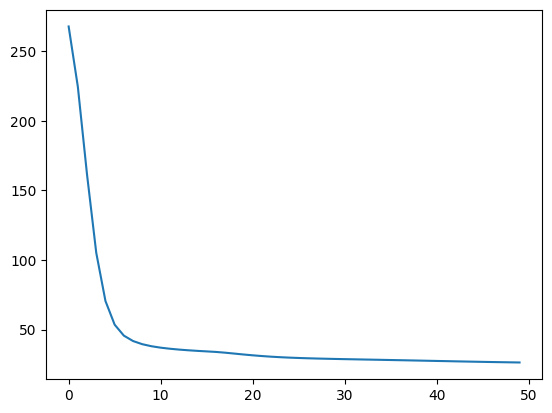

In [35]:
plt.plot(losses)

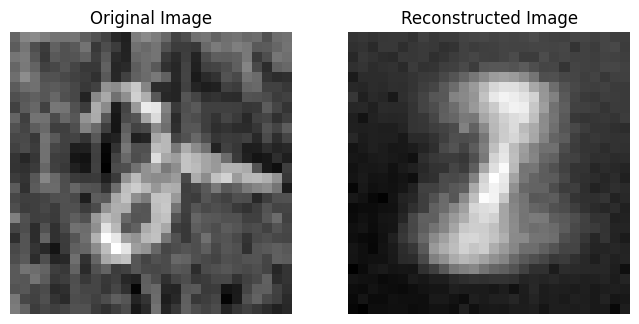

In [43]:
rand_idx = np.random.randint(0,10000)

x_input = target[rand_idx]
x_output = model(torch.tensor(x_input.astype("float32")))[0]

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,8))
ax1.axis("off"); ax2.axis("off");
ax1.set_title("Original Image");
ax2.set_title("Reconstructed Image");
ax1.imshow(x_input.reshape(28,28), cmap="gray")
ax2.imshow(x_output.detach().numpy().reshape(28,28), cmap="gray")

### cVAE (contrastive)

In [ ]:
# cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(
#     input_dim=784, intermediate_dim=32, latent_dim=2)

In [94]:
class ContrastiveVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, beta):
        super().__init__()

        self.z_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
               
        self.z_mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar_layer = nn.Linear(hidden_dim, latent_dim)
    
        self.s_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )

        self.s_mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.s_logvar_layer = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(2*latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )
    
    def reparameterization(self, mean, var):
        eps = torch.randn_like(var)
        return mean + var * eps
    
    def z_encode(self, x):
        x = self.z_encoder(x)
        mean, logvar = self.z_mean_layer(x), self.z_logvar_layer(x)
        z = self.reparameterization(mean, logvar)
        return z, mean, logvar

    def s_encode(self, x):
        x = self.s_encoder(x)
        mean, logvar = self.s_mean_layer(x), self.s_logvar_layer(x)
        s = self.reparameterization(mean, logvar)
        return s, mean, logvar

    def decode(self, x):
        return self.decoder(x)

    def forward(self, tg, bg):
        tg_z, tg_z_mean, tg_z_logvar = self.z_encode(tg)
        tg_s, tg_s_mean, tg_s_logvar = self.s_encode(tg)
        bg_s, bg_s_mean, bg_s_logvar = self.s_encode(bg)

        tg_outputs = self.decode(torch.cat((tg_z, tg_s), dim=-1))
        zeros = torch.zeros_like(tg_z)
        bg_outputs = self.decode(torch.cat((zeros, bg_s), dim=-1))
        fg_outputs = self.decode(torch.cat((tg_z, zeros), dim=-1))

        return tg_z_mean, tg_z_logvar, tg_s_mean, tg_s_logvar, bg_s_mean, bg_s_logvar, tg_outputs, bg_outputs, fg_outputs

In [108]:
def loss_function(tg_inputs, bg_inputs, tg_outputs, bg_outputs, tg_z_mean, tg_z_logvar, tg_s_mean, tg_s_logvar, bg_s_mean, bg_s_logvar, beta=1):
    reconstruction_loss_tg = F.mse_loss(tg_inputs, tg_outputs, reduction="sum")
    reconstruction_loss_bg = F.mse_loss(bg_inputs, bg_outputs, reduction="sum")
    reconstruction_loss = reconstruction_loss_tg + reconstruction_loss_bg
    
    kl_loss_tg_z = 1 + tg_z_logvar - tg_z_mean.pow(2) - tg_z_logvar.exp()
    kl_loss_tg_s = 1 + tg_s_logvar - tg_s_mean.pow(2) - tg_s_logvar.exp()
    kl_loss_bg_s = 1 + bg_s_logvar - bg_s_mean.pow(2) - bg_s_logvar.exp()
    kl_loss = -0.5 * torch.sum(kl_loss_tg_z + kl_loss_tg_s + kl_loss_bg_s)

    # print(reconstruction_loss)
    # print(kl_loss)
    return reconstruction_loss.mean() + kl_loss.mean()

In [110]:
def train(model, optimizer, epochs):
    model.train()
    
    losses = []
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(train_loader):
            # x = x.view(batch_size, -1)
            tg, bg = x[:,0,:], x[:,1,:]
            # print(tg.shape, bg.shape)
            
            optimizer.zero_grad()
            
            tg_z_mean, tg_z_logvar, tg_s_mean, tg_s_logvar, bg_s_mean, bg_s_logvar, tg_outputs, bg_outputs, fg_outputs = model(tg, bg)
            loss = loss_function(tg, bg, tg_outputs, bg_outputs, tg_z_mean, tg_z_logvar, tg_s_mean, tg_s_logvar, bg_s_mean, bg_s_logvar)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            
        # validation loss
        # val_data = torch.tensor(target.astype("float32"))

        tg_val = torch.tensor(target.astype("float32"))
        bg_val = torch.tensor(background.astype("float32"))
        
        tg_z_mean, tg_z_logvar, tg_s_mean, tg_s_logvar, bg_s_mean, bg_s_logvar, tg_outputs, bg_outputs, fg_outputs = model(tg_val, bg_val)
        val_loss = loss_function(tg_val, bg_val, tg_outputs, bg_outputs, tg_z_mean, tg_z_logvar, tg_s_mean, tg_s_logvar, bg_s_mean, bg_s_logvar)

        print(epoch, val_loss)
            
        # batch_loss = round(loss.item() / batch_size, 4)
        # losses.append(overall_loss / (batch_idx * batch_size))
        losses.append(overall_loss / len(target))
        avg_loss = round(overall_loss / (batch_idx * batch_size), 4)
        
        # print("\tEpoch", epoch, "\tAverage Loss: ", avg_loss)
        
    return losses

In [111]:
background.shape, target.shape

((10000, 784), (10000, 784))

In [112]:
# create dataloader

batch_size = 128
ds = torch.stack([torch.tensor(target.astype("float32")), torch.tensor(background.astype("float32"))], axis=1)
train_loader = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)

In [116]:
model = ContrastiveVAE(input_dim=28*28, hidden_dim=32, latent_dim=2, beta=1)
optimizer = Adam(model.parameters(), lr=1e-4)
losses = train(model, optimizer, epochs=100)

0 tensor(4305550.5000, grad_fn=<AddBackward0>)
1 tensor(3010906.7500, grad_fn=<AddBackward0>)
2 tensor(1829710.3750, grad_fn=<AddBackward0>)
3 tensor(1194107.3750, grad_fn=<AddBackward0>)
4 tensor(899223.3750, grad_fn=<AddBackward0>)
5 tensor(770671.7500, grad_fn=<AddBackward0>)
6 tensor(710781.3750, grad_fn=<AddBackward0>)
7 tensor(677943.3750, grad_fn=<AddBackward0>)
8 tensor(656864.9375, grad_fn=<AddBackward0>)
9 tensor(641631.9375, grad_fn=<AddBackward0>)
10 tensor(629820.0625, grad_fn=<AddBackward0>)
11 tensor(620107., grad_fn=<AddBackward0>)
12 tensor(611930.4375, grad_fn=<AddBackward0>)
13 tensor(604883.6250, grad_fn=<AddBackward0>)
14 tensor(598473.6875, grad_fn=<AddBackward0>)
15 tensor(592706.1250, grad_fn=<AddBackward0>)
16 tensor(587571.5625, grad_fn=<AddBackward0>)
17 tensor(582688.3750, grad_fn=<AddBackward0>)
18 tensor(578098.1250, grad_fn=<AddBackward0>)
19 tensor(573608.6250, grad_fn=<AddBackward0>)
20 tensor(569151., grad_fn=<AddBackward0>)
21 tensor(564681.7500, grad

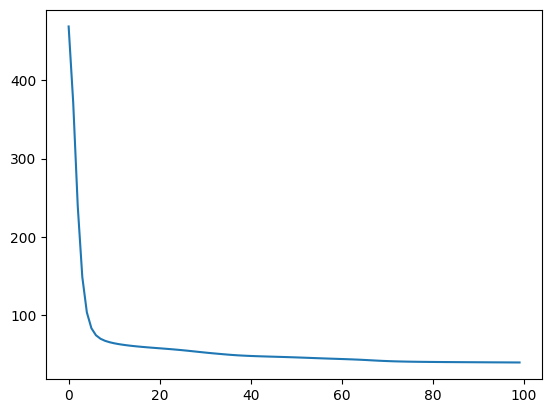

In [117]:
plt.plot(losses)

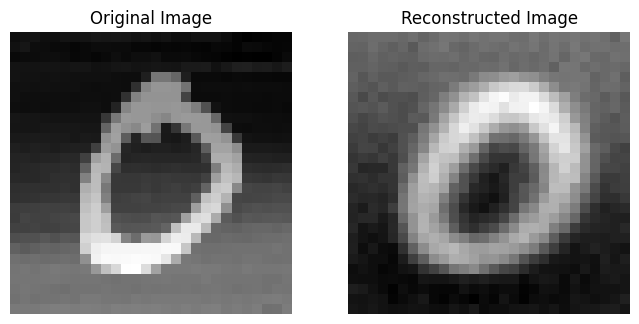

In [123]:
rand_idx = np.random.randint(0,10000)

tg_input = target[rand_idx]
bg_input = background[rand_idx]
x_output = model(
    torch.tensor(tg_input.astype("float32")),
    torch.tensor(bg_input.astype("float32")),
)[8]

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,8))
ax1.axis("off"); ax2.axis("off");
ax1.set_title("Original Image");
ax2.set_title("Reconstructed Image");
ax1.imshow(tg_input.reshape(28,28), cmap="gray")
ax2.imshow(x_output.detach().numpy().reshape(28,28), cmap="gray")

# numerical analysis